In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import sys,os
import matplotlib.pyplot as plt
import pandas as pd
import json


import ccxt
sys.path.append('../')
from core.database import ohlcv_functions
#from core.markets import market
from portfolio import portfolio_manager as pm

In [20]:
from core.database import database
from sqlalchemy.engine.reflection import Inspector 
from sqlalchemy.sql import select, and_
from sqlalchemy.exc import IntegrityError

In [16]:
engine = database.engine
conn = engine.connect()

                                                                              
inspector = Inspector.from_engine(engine)                                                                                        
print(inspector.get_table_names()) 
print(inspector.get_columns('OHLCV') )

['OHLCV', 'TradingOrders', 'TradingPairs']
[{'name': 'ID', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'Exchange', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Pair', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Timestamp', 'type': VARCHAR(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Open', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'High', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Low', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Close', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'Volume', 'type': FLOAT(), 

In [8]:
data=ohlcv_functions.get_latest_N_candles_as_df('kraken','BTC/USD','5m',10000)
data.head()

,ID,Exchange,Pair,Timestamp,Open,High,Low,Close,Volume,Interval,TimestampRaw,PairID
0,1127,kraken,BTC/USD,2018-02-07 19:40:00,8300.5,8300.6,8263.3,8289.5,13.872112,5m,1518025200000,1
1,1126,kraken,BTC/USD,2018-02-07 19:35:00,8194.7,8318.0,8193.6,8300.7,50.285346,5m,1518024900000,1
2,1125,kraken,BTC/USD,2018-02-07 19:30:00,8201.1,8206.0,8190.0,8194.7,18.511864,5m,1518024600000,1
3,1124,kraken,BTC/USD,2018-02-07 19:25:00,8248.1,8248.2,8224.1,8224.5,10.360175,5m,1518024300000,1
4,1123,kraken,BTC/USD,2018-02-07 19:20:00,8200.9,8248.3,8195.0,8224.0,36.281021,5m,1518024000000,1


/Users/yabebal/anaconda/envs/crypto/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


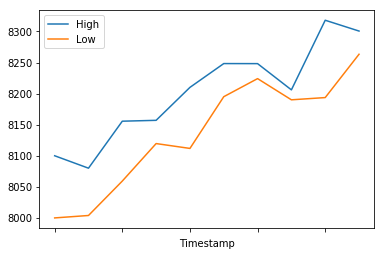

In [15]:
# Library to explore visualization of API data. Critical to ensure data integrity as 
# well as confirm strategy indicators are calculated correctly .


def historical_ta_plot(historical_status):
    """Make basic matplotlib line chart with close and moving 
    averages on the Y axis for historical data and new candles
    """
    if historical_status:
        #data = ohlcv_functions.get_historical_ta_data_as_df()
        data=ohlcv_functions.get_latest_N_candles_as_df('kraken','BTC/USD','5m',10)
        data.sort_values('Timestamp').plot(x='Timestamp', y=['High','Low'])
        plt.show()


historical_ta_plot(True)

In [25]:
table=database.TradingOrders
def get_number_of_trades(exchange, pair):
    s = select([func.count()]).where(and_(database.TradingOrders.c.Exchange == exchange, database.TradingOrders.c.Pair == pair)).select_from(database.TradingOrders)
    result = conn.execute(s)
    return int(result)


def get_trades_for_pair_as_df(exchange, pair):
    """Returns all trades for given exchange pair over the course of trading in a dataframe"""
    s = select([database.TradingOrders]).where(and_(database.TradingOrders.c.Exchange == exchange, database.TradingOrders.c.Pair == pair))
    result = conn.execute(s)
    df = pd.DataFrame(result.fetchall())
    df.columns = result.keys()
    result.close()
    return df

def get_profit_for_pair(exchange, pair):
    """Iterates through all trades for given exchange pair over the course of trading. Starts by subtracting the long positions (the buys) 
and adding the short positions (the sells) to arrive at the difference (profit"""
    """The buys are always the even rows and the sells are the odd rows (buy always before sell starting from zero)"""
    profit = 0
    counter = 0
    s = select([database.TradingOrders]).where(and_(database.TradingOrders.c.Exchange == exchange, database.TradingOrders.c.Pair == pair))
    result = conn.execute(s)

    for row in result:
        if counter % 2 == 0:
            profit = profit - row[5]
            counter += 1
        else:
            profit = profit + row[5]
            counter += 1
        return profit


trade=get_trades_for_pair_as_df('kraken', 'BTC/USD')
trade.head()

,Timestamp,OrderID,Exchange,Pair,Position,Amount,Price,Simulated
0,2018-02-07 18:36:22,1,kraken,BTC/USD,buy,1.0,8100.0,simulated
1,2018-02-07 18:36:22,2,kraken,BTC/USD,sell,1.0,8120.0,simulated
2,2018-02-07 18:36:22,3,kraken,BTC/USD,buy,1.0,8120.0,simulated
3,2018-02-07 18:36:22,4,kraken,BTC/USD,sell,1.0,8171.5,simulated
4,2018-02-07 18:36:22,5,kraken,BTC/USD,buy,1.0,8171.5,simulated


/Users/yabebal/anaconda/envs/crypto/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


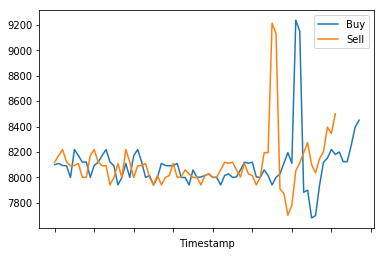

In [36]:
ax=plt.subplot()
trade[trade['Position']=="buy"].sort_values('Timestamp').plot(x='Timestamp', y=['Price'],ax=ax)
trade[trade['Position']=="sell"].sort_values('Timestamp').plot(x='Timestamp', y=['Price'],ax=ax)
ax.legend(["Buy", "Sell"]);

### Converting tick-by-tick data to OHLC data using pandas

In [47]:
#https://www.quantinsti.com/blog/tick-tick-ohlc-data-pandas-tutorial/

exchange_name='bitstamp'
api_kv=json.load(open(f'/Users/yabebal/.crypto/{exchange_name}.json'))



exchange_func = getattr(ccxt, exchange_name)
exchange=exchange_func(api_kv)
res=exchange.fetch_ticker('ETH/EUR')

print(res)


{'symbol': 'ETH/EUR', 'timestamp': 1518125079000, 'datetime': '2018-02-08T21:24:39.000Z', 'high': 694.01, 'low': 606.49, 'bid': 652.62, 'ask': 655.98, 'vwap': 656.56, 'open': 611.84, 'close': None, 'first': None, 'last': 652.55, 'change': None, 'percentage': None, 'average': None, 'baseVolume': 21566.49575298, 'quoteVolume': 14159698.451576548, 'info': {'high': '694.01', 'last': '652.55', 'timestamp': '1518125079', 'bid': '652.62', 'vwap': '656.56', 'volume': '21566.49575298', 'low': '606.49', 'ask': '655.98', 'open': '611.84'}}


In [43]:
data_frame = pd.read_csv('AUDJPY-2016-01.csv', names=['Symbol', 'Date_Time', 'Bid', 'Ask'],

index_col=1, parse_dates=True)

data_frame.head()

data_ask =  data_frame['Ask'].resample('15Min').ohlc()

data_bid =  data_frame['Bid'].resample('15Min').ohlc()

data_ask.head()

data_bid.head()

data_ask_bid=pd.concat([data_ask, data_bid], axis=1, keys=['Ask', 'Bid'])

FileNotFoundError: File b'AUDJPY-2016-01.csv' does not exist

In [48]:
from pyalgotrade.bitstamp import client
from pyalgotrade.bitstamp import barfeed
from pyalgotrade.bitstamp import broker
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross


class Strategy(strategy.BaseStrategy):
    def __init__(self, cli, feed, brk):
        strategy.BaseStrategy.__init__(self, feed, brk)
        smaPeriod = 20
        self.__instrument = "BTC"
        self.__prices = feed[self.__instrument].getCloseDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)
        self.__bid = None
        self.__ask = None
        self.__position = None
        self.__posSize = 0.05

        # Subscribe to order book update events to get bid/ask prices to trade.
        cli.getOrderBookUpdateEvent().subscribe(self.__onOrderBookUpdate)

    def __onOrderBookUpdate(self, orderBookUpdate):
        bid = orderBookUpdate.getBidPrices()[0]
        ask = orderBookUpdate.getAskPrices()[0]

        if bid != self.__bid or ask != self.__ask:
            self.__bid = bid
            self.__ask = ask
            self.info("Order book updated. Best bid: %s. Best ask: %s" % (self.__bid, self.__ask))

    def onEnterOk(self, position):
        self.info("Position opened at %s" % (position.getEntryOrder().getExecutionInfo().getPrice()))

    def onEnterCanceled(self, position):
        self.info("Position entry canceled")
        self.__position = None

    def onExitOk(self, position):
        self.__position = None
        self.info("Position closed at %s" % (position.getExitOrder().getExecutionInfo().getPrice()))

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitLimit(self.__bid)

    def onBars(self, bars):
        bar = bars[self.__instrument]
        self.info("Price: %s. Volume: %s." % (bar.getClose(), bar.getVolume()))

        # Wait until we get the current bid/ask prices.
        if self.__ask is None:
            return

        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                self.info("Entry signal. Buy at %s" % (self.__ask))
                self.__position = self.enterLongLimit(self.__instrument, self.__ask, self.__posSize, True)
        # Check if we have to close the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.info("Exit signal. Sell at %s" % (self.__bid))
            self.__position.exitLimit(self.__bid)


def main():
    cli = client.Client()
    barFeed = barfeed.LiveTradeFeed(cli)
    brk = broker.PaperTradingBroker(1000, barFeed)
    strat = Strategy(cli, barFeed, brk)

    # It is VERY important to add the client to the event dispatch loop before running the strategy.
    strat.getDispatcher().addSubject(cli)
    strat.run()

#if __name__ == "__main__":
main()

ImportError: cannot import name 'client'